#**Visualizing The Vaccination Rollout And Predicting Herd Immunity**

##**Preparing The Data**

### **Importing the Dataset And Various Packages**

In [ ]:
#install the dependencies
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"patrickgg","key":"9c45caf9358f7bbf30870f38a588428d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d gpreda/covid-world-vaccination-progress

  0% 0.00/360k [00:00<?, ?B/s]
100% 360k/360k [00:00<00:00, 50.8MB/s]


In [ ]:
from zipfile import ZipFile
file_name="covid-world-vaccination-progress.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
import statsmodels.api as sm
import datetime
import statsmodels.formula.api as smf
import numpy as np
import sqlite3 as sql
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
conn = sql.connect('example.db')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Cleaning Up The Data

In [ ]:
# Import data as dataframe vacc
vaccination = pd.read_csv("country_vaccinations.csv")

# Dropping the columns source name & source website as they are not relevant to the study
vaccination.drop(['source_name','source_website'], inplace=True, axis=1)

vaccination = vaccination.drop(vaccination[vaccination.people_fully_vaccinated_per_hundred.isna()].index)

In [ ]:
vaccination['date'] = pd.to_datetime(vaccination['date'], utc=True)
vaccination_start = vaccination.loc[vaccination[vaccination.people_fully_vaccinated_per_hundred > 0].groupby('country')['date'].idxmin()].sort_values('date')
vaccination_start.head(5)
vaccination

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
83,Albania,ALB,2021-02-02 00:00:00+00:00,550.0,549.0,1.0,NaN,0.0,0.02,0.02,0.00,0.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ..."
90,Albania,ALB,2021-02-09 00:00:00+00:00,1127.0,689.0,438.0,NaN,82.0,0.04,0.02,0.02,28.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ..."
98,Albania,ALB,2021-02-17 00:00:00+00:00,1701.0,1090.0,611.0,NaN,72.0,0.06,0.04,0.02,25.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ..."
99,Albania,ALB,2021-02-18 00:00:00+00:00,3049.0,2438.0,611.0,1348.0,254.0,0.11,0.08,0.02,88.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ..."
103,Albania,ALB,2021-02-22 00:00:00+00:00,6728.0,6073.0,655.0,NaN,739.0,0.23,0.21,0.02,257.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15661,Zimbabwe,ZWE,2021-05-02 00:00:00+00:00,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing
15662,Zimbabwe,ZWE,2021-05-03 00:00:00+00:00,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing
15663,Zimbabwe,ZWE,2021-05-04 00:00:00+00:00,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing
15664,Zimbabwe,ZWE,2021-05-05 00:00:00+00:00,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing


In [ ]:
DFV=pd.read_csv('country_vaccinations.csv')
DFV


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...


In [ ]:


#Merge UK countries
DFV['country'].replace(['England', 'Wales', 'Scotland', 'Northern Ireland'], 'United Kingdom', inplace = True)

#Change Northern Cyprus to Cyprus
DFV['country'].replace(['Northern Cyprus'], 'Cyprus', inplace = True)

DFV[(DFV['iso_code'].isna())]

DFV[(DFV['iso_code'].isna()) & (DFV['country']=='United Kingdom')]
#replace all Nan with GBR
DFV.iso_code.fillna('GBR', inplace=True)
DFV

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...


In [ ]:
#creating week, month and year column
Dates=pd.to_datetime(DFV['date'])
DFV['Month']=Dates.dt.month
DFV['Week']=Dates.dt.isocalendar().week
DFV['Year']=Dates.dt.year

#change Month Week and Year to STR
DFV['Month']=DFV['Month'].astype(str)
DFV['Week']=DFV['Week'].astype(str)
DFV['Year']=DFV['Year'].astype(str)


In [ ]:
#change week 53 to correct week of year
DFV['Week'] = np.where((DFV['date'] <= '2021-01-07') & (DFV['Week'] =='53') & (DFV['Year']=='2021'), '1', DFV['Week']) 
DFV['Week'] = np.where((DFV['date'] >= '2020-12-26') & (DFV['Week'] =='53') & (DFV['Year']=='2020'), '52', DFV['Week']) 

In [ ]:
#creating Year_month column and year_week column
DFV['year_month']=DFV['Year']+"-"+DFV['Month']
DFV['year_week']=DFV['Year']+"-"+DFV['Week']

In [ ]:
#create Month dataframe and Week Dataframe
DFV_Month=DFV.groupby(['year_month']).sum()
DFV_Week=DFV.groupby(['year_week']).sum()

### **Creating Monthly, Weekly and Daily DataFrames**

In [ ]:
DFMonth=DFV.groupby(['year_month','Month']).sum()

In [ ]:
Monthly_vaccination_World=DFV_Month[['daily_vaccinations']].sort_values('year_month',ascending=True)
Monthly_vaccination_World=Monthly_vaccination_World.groupby(['year_month'])["daily_vaccinations"].sum().reset_index()
Monthly_vaccination_World['total_cumulated']=Monthly_vaccination_World['daily_vaccinations'].cumsum()

In [ ]:
Weekly_vaccination_World=DFV_Week[['daily_vaccinations']].sort_values('year_week',ascending=True)
Weekly_vaccination_World=Weekly_vaccination_World.groupby(['year_week'])["daily_vaccinations"].sum().reset_index()
Weekly_vaccination_World['total_cumulated']=Weekly_vaccination_World['daily_vaccinations'].cumsum()

In [ ]:
daily_vaccination_World=DFV[['date','daily_vaccinations']].sort_values('date',ascending=True)
daily_vaccination_World=daily_vaccination_World.groupby(['date'])["daily_vaccinations"].sum().reset_index()
daily_vaccination_World['total_cumulated']=daily_vaccination_World['daily_vaccinations'].cumsum()

In [ ]:
daily_vaccination_World

,date,daily_vaccinations,total_cumulated
0,2020-12-14,0.0,0.000000e+00
1,2020-12-15,718.0,7.180000e+02
2,2020-12-16,192366.0,1.930840e+05
3,2020-12-17,193256.0,3.863400e+05
4,2020-12-18,193649.0,5.799890e+05
...,...,...,...
139,2021-05-02,19995640.0,1.158071e+09
140,2021-05-03,19292226.0,1.177363e+09
141,2021-05-04,18816094.0,1.196179e+09
142,2021-05-05,18135652.0,1.214315e+09


### **Note On Predictions**
When predicting the amount of time until a population is fully vaccinated, I decided to look at the most recent data for the percent of the population that is fully vaccinated and the number of people fully vaccinated to find the total population. I used the same total population, percent of people fully vaccinated and number of people fully vaccinated for the Weekly, Monthly and Daily predictions. The reason that I went for population fully vaccinated instead of total vaccinations, is that it will be a better indicator of when vaccinations are no longer required.

In the last section of this notebook, we will be predicting around what date should Israel and the United States reach herd immunity



#**Visualizing The Vaccination Project**

## World Data

###Top 25 Countries In Terms Of Total Vaccinations

In [ ]:
TVP=DFV.groupby(['country'])['total_vaccinations'].max().reset_index()
TVP=TVP.nlargest(25,['total_vaccinations']).reset_index()


top_25=TVP['country']
fig = px.bar(TVP, x="country", y="total_vaccinations", title='Top 25 Countries In Amount Of Total Vaccinations')
fig.show()

###Top 25 Countries In Terms Of People Fully Vaccinated

In [ ]:
TV=DFV.groupby(['country'])['people_fully_vaccinated'].max().reset_index()

In [ ]:
#ranking countries total vaccinations
TV=DFV.groupby(['country'])['people_fully_vaccinated'].max().reset_index()
TV=TV.nlargest(25,['people_fully_vaccinated']).reset_index()


top_25=TV['country']
fig = px.bar(TV, x="country", y="people_fully_vaccinated", title='Top 25 Countries In Number Of People Fully Vaccinated')
fig.show()

###Top 25 Countries In Terms Of The Percentage Of The Population That Is Fully Vaccinated

In [ ]:
#ranking countries people vaccinated per hundred
TVP=DFV.groupby(['country'])['people_fully_vaccinated_per_hundred'].max().reset_index()
TVP=TVP.nlargest(25,['people_fully_vaccinated_per_hundred']).reset_index()


top_25=TVP['country']
fig = px.bar(TVP, x="country", y="people_fully_vaccinated_per_hundred", title='Top 25 Countries In Percentage Of Number Of People Fully Vaccinated')
fig.show()

### Worldwide Daily Vaccination Trend

In [ ]:
#daily vaccines worldwide
import plotly.express as px

fig = px.line(daily_vaccination_World, x="date", y="daily_vaccinations", title='Daily Vaccinations Across The World')
fig.show()

### Worldwide Cumulative Daily Vaccinations



In [ ]:
#daily cumulative vaccines worldwide
import plotly.express as px

fig = px.line(daily_vaccination_World, x="date", y="total_cumulated", title='Cumulative Daily Vaccinations Across The World')
fig.show()

###  Monthly Data Across The World

In [ ]:
DFMonth=DFV.groupby(['year_month','Month']).sum()

In [ ]:
DFV['date'] = pd.to_datetime(DFV['date'])
DF=DFV.sort_values('date')
DFMonths=DF['date'].apply(lambda x:x.strftime('%B'))
DFMONTH=DFMonths.unique().tolist()
DFMonth=DFV.groupby(['year_month','Month']).sum()
DFMonth.insert(1,'Months',DFMONTH,True)
DFMonth['total_cumulated']=DFMonth['daily_vaccinations'].cumsum()

### Worldwide Monthly Vaccination Trend

In [ ]:
fig = px.bar(DFMonth, x='Months',y="daily_vaccinations", title='Monthly Vaccinations Across The World')

fig.show()

### Worldwide Cumulative Monthly Vaccinations

In [ ]:
fig = px.bar(DFMonth,x='Months', y="total_cumulated", title='Cumulative Monthly Vaccinations Across The World')

fig.show()

**I chose to analyze the three countries leading in terms of percentage of population fully vaccinated.**

## Israel's Vaccination Data

In [ ]:
#Israel

DF_Israel=DFV[DFV["country"]=='Israel'].copy()
daily_vaccination_Israel=DF_Israel[['date','daily_vaccinations']].sort_values('date',ascending=True)
daily_vaccination_Israel=daily_vaccination_Israel.groupby(['date'])["daily_vaccinations"].sum().reset_index()
daily_vaccination_Israel['total_cumulated']=daily_vaccination_Israel['daily_vaccinations'].cumsum()
DF_Israel_Month=DF_Israel.groupby(['year_month']).sum()
Monthly_vaccination_Israel=DF_Israel_Month[['daily_vaccinations']].sort_values('year_month',ascending=True)
Monthly_vaccination_Israel=Monthly_vaccination_Israel.groupby(['year_month'])["daily_vaccinations"].sum().reset_index()
Monthly_vaccination_Israel['total_cumulated']=Monthly_vaccination_Israel['daily_vaccinations'].cumsum()
DFV_Israel_Week=DF_Israel.groupby(['year_week']).sum()
Weekly_vaccination_Israel=DFV_Israel_Week[['daily_vaccinations']].sort_values('year_week',ascending=True)
Weekly_vaccination_Israel=Weekly_vaccination_Israel.groupby(['year_week'])["daily_vaccinations"].sum().reset_index()
Weekly_vaccination_Israel['total_cumulated']=Weekly_vaccination_Israel['daily_vaccinations'].cumsum()


## Israel's Daily Vaccination Data

###Israel's Daily Vaccination Trend

In [ ]:
#daily vaccines Israel
import plotly.express as px

fig = px.line(daily_vaccination_Israel, x="date", y="daily_vaccinations", title='Daily Vaccinations Across Israel')
fig.show()

###Israel's Cumulative Daily Vaccinations

In [ ]:
#daily vaccines Israel
import plotly.express as px

fig = px.line(daily_vaccination_Israel, x="date", y="total_cumulated", title='Cumulative Daily Vaccinations Across Israel')
fig.show()

## Israel's Monthly Vaccination Data

In [ ]:
DFMonthIsrael=DF_Israel.groupby(['year_month','Month']).sum()

In [ ]:
DF_Israel['date'] = pd.to_datetime(DF_Israel['date'])
DF_Israel_Monthsss=DF_Israel['date'].apply(lambda x:x.strftime('%B'))
DFMONTHIsrael=DF_Israel_Monthsss.unique().tolist()
DFMonthIsrael=DF_Israel.groupby(['year_month','Month']).sum()
DFMonthIsrael.insert(1,'Month',DFMONTHIsrael,True)
DFMonthIsrael['total_cumulated']=DFMonthIsrael['daily_vaccinations'].cumsum()

###Israel's Monthly Vaccination Trend

In [ ]:
fig = px.bar(DFMonthIsrael,x='Month', y="daily_vaccinations", title='Monthly Vaccinations Across Israel')
fig.show()


###Israel's Cumulative Monthly Vaccinations

In [ ]:
fig = px.bar(DFMonthIsrael,x='Month', y="total_cumulated", title='Cumulative Monthly Vaccinations Across Israel')
fig.show()


#**Gibraltar Vaccination Data**

In [ ]:
#Gibraltar
DF_Gibraltar=DFV[DFV["country"]=='Gibraltar'].copy()


daily_vaccination_Gibraltar=DF_Gibraltar[['date','daily_vaccinations']].sort_values('date',ascending=True)
daily_vaccination_Gibraltar=daily_vaccination_Gibraltar.groupby(['date'])["daily_vaccinations"].sum().reset_index()
daily_vaccination_Gibraltar['total_cumulated']=daily_vaccination_Gibraltar['daily_vaccinations'].cumsum()
DF_Gibraltar_Month=DF_Gibraltar.groupby(['year_month']).sum()
Monthly_vaccination_Gibraltar=DF_Gibraltar_Month[['daily_vaccinations']].sort_values('year_month',ascending=True)
Monthly_vaccination_Gibraltar=Monthly_vaccination_Gibraltar.groupby(['year_month'])["daily_vaccinations"].sum().reset_index()
Monthly_vaccination_Gibraltar['total_cumulated']=Monthly_vaccination_Gibraltar['daily_vaccinations'].cumsum()
DFV_Gibraltar_Week=DF_Gibraltar.groupby(['year_week']).sum()
Weekly_vaccination_Gibraltar=DFV_Gibraltar_Week[['daily_vaccinations']].sort_values('year_week',ascending=True)
Weekly_vaccination_Gibraltar=Weekly_vaccination_Gibraltar.groupby(['year_week'])["daily_vaccinations"].sum().reset_index()
Weekly_vaccination_Gibraltar['total_cumulated']=Weekly_vaccination_Gibraltar['daily_vaccinations'].cumsum()

##Gibraltar's Daily Vaccination Data

###Gibraltar's Daily Vaccination Trend

In [ ]:
#daily vaccines Gibraltar
import plotly.express as px

fig = px.line(daily_vaccination_Gibraltar, x="date", y="daily_vaccinations", title='Daily Vaccinations Across Gibraltar')
fig.show()

##Gibraltar's Cumulative Daily Vaccinations

In [ ]:
#daily vaccines Gibraltar
import plotly.express as px

fig = px.line(daily_vaccination_Gibraltar, x="date", y="total_cumulated", title='Cumulative Daily Vaccinations Across Gibraltar')
fig.show()

## **Gibraltar's Monthly Vaccination Data**

In [ ]:
DF_Gibraltar['date'] = pd.to_datetime(DF_Gibraltar['date'])
DF_Gibraltar_Monthsss=DF_Gibraltar['date'].apply(lambda x:x.strftime('%B'))
DFMONTHGibraltar=DF_Gibraltar_Monthsss.unique().tolist()

In [ ]:
DFMonthGibraltar=DF_Gibraltar.groupby(['year_month','Month']).sum()
DFMonthGibraltar.insert(1,'Month',DFMONTHGibraltar,True)
DFMonthGibraltar['total_cumulated']=DFMonthGibraltar['daily_vaccinations'].cumsum()

###**Gibraltar's Monthly Vaccination Trend**

In [ ]:
fig = px.bar(DFMonthGibraltar,x='Month', y="daily_vaccinations", title='Monthly Vaccinations Across Gibraltar')

fig.show()

###**Gibraltar's Cumulative Monthly Vaccinations**

In [ ]:
fig = px.bar(DFMonthGibraltar,x='Month', y="total_cumulated", title='Monthly Vaccinations Across Gibraltar')

fig.show()

# **Seychelles' Vaccination Data**

In [ ]:
#Seychelles
DF_Seychelles=DFV[DFV["country"]=='Seychelles'].copy()
DF_Seychelles['date'] = pd.to_datetime(DF_Seychelles['date'])
daily_vaccination_Seychelles=DF_Seychelles[['date','daily_vaccinations']].sort_values('date',ascending=True)
daily_vaccination_Seychelles=daily_vaccination_Seychelles.groupby(['date'])["daily_vaccinations"].sum().reset_index()
daily_vaccination_Seychelles['total_cumulated']=daily_vaccination_Seychelles['daily_vaccinations'].cumsum()
DF_Seychelles_Month=DF_Seychelles.groupby(['year_month']).sum()
Monthly_vaccination_Seychelles=DF_Seychelles_Month[['daily_vaccinations']].sort_values('year_month',ascending=True)
Monthly_vaccination_Seychelles=Monthly_vaccination_Seychelles.groupby(['year_month'])["daily_vaccinations"].sum().reset_index()
Monthly_vaccination_Seychelles['total_cumulated']=Monthly_vaccination_Seychelles['daily_vaccinations'].cumsum()
DFV_Seychelles_Week=DF_Seychelles.groupby(['year_week']).sum()
Weekly_vaccination_Seychelles=DFV_Seychelles_Week[['daily_vaccinations']].sort_values('year_week',ascending=True)
Weekly_vaccination_Seychelles=Weekly_vaccination_Seychelles.groupby(['year_week'])["daily_vaccinations"].sum().reset_index()
Weekly_vaccination_Seychelles['total_cumulated']=Weekly_vaccination_Seychelles['daily_vaccinations'].cumsum()

## **Seychelles Daily Vaccination Data**

###**Seychelles' Daily Vaccination Trend**

In [ ]:
#daily vaccines Seychelles
import plotly.express as px

fig = px.line(daily_vaccination_Seychelles, x="date", y="daily_vaccinations", title='Daily Vaccinations Across Seychelles')
fig.show()

###**Seychelles' Cumulative Daily Vaccinations**

In [ ]:
#daily vaccines Seychelles
import plotly.express as px

fig = px.line(daily_vaccination_Seychelles, x="date", y="total_cumulated", title='Cumulative Daily Vaccinations Across Seychelles')
fig.show()

## **Seychelles Monthly Vaccination Data**

In [ ]:
DF_Seychelles['date'] = pd.to_datetime(DF_Seychelles['date'])
DF_Seychelles_Monthsss=DF_Seychelles['date'].apply(lambda x:x.strftime('%B'))
DFMONTHSEYCHELLES=DF_Seychelles_Monthsss.unique().tolist()

In [ ]:
DFMonthSeychelles=DF_Seychelles.groupby(['year_month','Month']).sum()
DFMonthSeychelles.insert(1,'Months',DFMONTHSEYCHELLES,True)
DFMonthSeychelles['total_cumulated']=DFMonthSeychelles['daily_vaccinations'].cumsum()

###**Seychelles' Monthly Vaccination Trend**

In [ ]:
fig = px.bar(DFMonthSeychelles,x='Months', y="daily_vaccinations", title='Monthly Vaccinations Across Seychelles')

fig.show()

###**Seychelles' Cumulative Monthly Vaccinations**

In [ ]:
fig = px.bar(DFMonthSeychelles,x='Months', y="total_cumulated", title='Cumulative Monthly Vaccinations Across Seychelles')

fig.show()

In [ ]:
DFVCA=DFV[DFV['country']=='Israel']
DFVCA

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Month,Week,Year,year_month,year_week
6992,Israel,ISR,2020-12-19,61.0,61.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,12,51,2020,2020-12,2020-51
6993,Israel,ISR,2020-12-20,7436.0,7436.0,NaN,7375.0,7375.0,0.09,0.09,NaN,852.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,12,51,2020,2020-12,2020-51
6994,Israel,ISR,2020-12-21,32318.0,32318.0,NaN,24882.0,16128.0,0.37,0.37,NaN,1863.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,12,52,2020,2020-12,2020-52
6995,Israel,ISR,2020-12-22,76938.0,76938.0,NaN,44620.0,25626.0,0.89,0.89,NaN,2961.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,12,52,2020,2020-12,2020-52
6996,Israel,ISR,2020-12-23,139779.0,139779.0,NaN,62841.0,34930.0,1.61,1.61,NaN,4036.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,12,52,2020,2020-12,2020-52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7126,Israel,ISR,2021-05-02,10459346.0,5404275.0,5055071.0,9087.0,8726.0,120.84,62.44,58.40,1008.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,5,17,2021,2021-5,2021-17
7127,Israel,ISR,2021-05-03,10468341.0,5407666.0,5060675.0,8995.0,8185.0,120.94,62.48,58.47,946.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,5,18,2021,2021-5,2021-18
7128,Israel,ISR,2021-05-04,10476214.0,5411033.0,5065181.0,7873.0,7774.0,121.03,62.52,58.52,898.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,5,18,2021,2021-5,2021-18
7129,Israel,ISR,2021-05-05,10482976.0,5414047.0,5068929.0,6762.0,7118.0,121.11,62.55,58.56,822.0,"Moderna, Pfizer/BioNTech",Government of Israel,https://datadashboard.health.gov.il/COVID-19/g...,5,18,2021,2021-5,2021-18


#**Time-Series Analysis For When A Country Will Achieve Herd-Immunity**
Since observing the mean vaccination rate may not be the best to determine total vaccination. Let us try instead to reach herd immunity by fully vaccinating at least 70% of the population.
This 70% benchmark was provided by the John Hopkins Bloomberg School of Public Health. Let us take a look at the United States that has been a leader in terms of total vaccinations administered, but use a higher benchmark since with the variants, the herd-immunity with likely require a higher percentage of the population vaccinated.



In [ ]:

vacc = pd.read_csv("country_vaccinations.csv")


vacc.drop(['source_name','source_website'], inplace=True, axis=1)

In [ ]:
vacc = vacc.drop(vacc[vacc.people_fully_vaccinated_per_hundred.isna()].index)

In [ ]:
vacc['date'] = pd.to_datetime(vacc['date'], utc=True)
vacc_start = vacc.loc[vacc[vacc.people_fully_vaccinated_per_hundred > 0].groupby('country')['date'].idxmin()].sort_values('date')
vacc_start.head(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
14969,United Kingdom,GBR,2021-01-03 00:00:00+00:00,1402432.0,1380430.0,22002.0,NaN,NaN,2.07,2.03,0.03,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
4197,England,OWID_ENG,2021-01-03 00:00:00+00:00,1193335.0,1172675.0,20660.0,NaN,NaN,2.12,2.08,0.04,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
10490,Northern Ireland,OWID_NIR,2021-01-03 00:00:00+00:00,41956.0,40685.0,1271.0,NaN,NaN,2.22,2.15,0.07,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
2413,Canada,CAN,2021-01-08 00:00:00+00:00,260654.0,258627.0,2027.0,41208.0,22409.0,0.69,0.69,0.01,594.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
12575,Scotland,OWID_SCT,2021-01-10 00:00:00+00:00,166135.0,163377.0,2758.0,NaN,7111.0,3.04,2.99,0.05,1302.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"


##USA

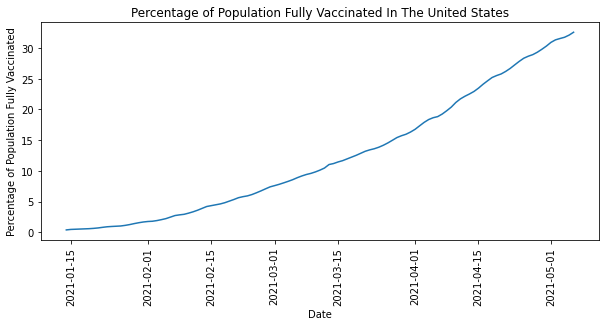

In [ ]:
usa_stats = vacc[vacc.country == 'United States']

plt.figure(figsize=(10, 4)) 
plt.plot(usa_stats.date, usa_stats.people_fully_vaccinated_per_hundred)
plt.xticks(rotation=90)
plt.title('Percentage of Population Fully Vaccinated In The United States')
plt.xlabel('Date')
plt.ylabel('Percentage of Population Fully Vaccinated')
plt.show()

In [ ]:
usa_stats_sliced = usa_stats.loc[:,['date','people_fully_vaccinated_per_hundred']]
usa_stats_sliced.head(-5)

,date,people_fully_vaccinated_per_hundred
15117,2021-01-14 00:00:00+00:00,0.40
15118,2021-01-15 00:00:00+00:00,0.48
15122,2021-01-19 00:00:00+00:00,0.60
15123,2021-01-20 00:00:00+00:00,0.65
15124,2021-01-21 00:00:00+00:00,0.72
...,...,...
15220,2021-04-27 00:00:00+00:00,28.93
15221,2021-04-28 00:00:00+00:00,29.32
15222,2021-04-29 00:00:00+00:00,29.80
15223,2021-04-30 00:00:00+00:00,30.32


In [ ]:
usa_stats_sliced["t"] = (usa_stats_sliced['date'] - usa_stats_sliced.date.iloc[0]).dt.days + 1
usa_stats_sliced["t_squared"] = usa_stats_sliced["t"]*usa_stats_sliced["t"]
usa_stats_sliced["log"] = np.log(usa_stats_sliced["t"])
usa_stats_sliced["exp"] = np.log(usa_stats_sliced["people_fully_vaccinated_per_hundred"])


In [ ]:
Train = usa_stats_sliced.iloc[0:int(np.floor(0.8*len(usa_stats_sliced))),:]
Test = usa_stats_sliced.iloc[int(np.floor(0.8*len(usa_stats_sliced))):,:]

In [ ]:
# Testing trend on linear model
linear_model = smf.ols('people_fully_vaccinated_per_hundred ~ t', data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['people_fully_vaccinated_per_hundred'])-np.array(pred_linear))**2))

# Testing trend on exponential model
Exp = smf.ols('exp ~ t', data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['people_fully_vaccinated_per_hundred'])-np.array(np.exp(pred_Exp)))**2))

# Testing trend on quadratic model
Quad = smf.ols('people_fully_vaccinated_per_hundred ~ t + t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['people_fully_vaccinated_per_hundred'])-np.array(pred_Quad))**2))

# Testing trend on log model
Log = smf.ols('people_fully_vaccinated_per_hundred ~ log',data=Train).fit()
pred_Log = pd.Series(Log.predict(pd.DataFrame(Test[["log"]])))
rmse_Log = np.sqrt(np.mean((np.array(Test['people_fully_vaccinated_per_hundred'])-np.array(pred_Log))**2))



In [ ]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_Log"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_Log])}
table_rmse=pd.DataFrame(data)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,5.638261
1,rmse_Exp,30.024653
2,rmse_Quad,0.580916
3,rmse_Log,13.226657


In [ ]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     people_fully_vaccinated_per_hundred   R-squared:                       0.999
Model:                                             OLS   Adj. R-squared:                  0.999
Method:                                  Least Squares   F-statistic:                 3.642e+04
Date:                                 Mon, 10 May 2021   Prob (F-statistic):          3.81e-124
Time:                                         20:20:53   Log-Likelihood:                 6.6287
No. Observations:                                   87   AIC:                            -7.257
Df Residuals:                                       84   BIC:                            0.1404
Df Model:                                            2                                         
Covariance Type:                             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0872      0.083      1.052      0.296      -0.078       0.252
t              0.0564      0.004     14.055      0.000       0.048       0.064
t_squared      0.0021   4.13e-05     50.482      0.000       0.002       0.002
==============================================================================
Omnibus:                        0.238   Durbin-Watson:                   0.163
Prob(Omnibus):                  0.888   Jarque-Bera (JB):                0.423
Skew:                           0.029   Prob(JB):                        0.809
Kurtosis:                       2.663   Cond. No.                     1.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
t_data = pd.Series(list(range(usa_stats_sliced.t.iloc[-1] + 1, usa_stats_sliced.t.iloc[-1] + 600)))

t_squared_data = t_data*t_data

pred_x = pd.DataFrame({'t':t_data, 't_squared':t_squared_data})

In [ ]:
pred_y = Quad.predict(pred_x)
days_after = (pred_y > 80).idxmax() + 1 
herd_date = usa_stats.iloc[-1].date + datetime.timedelta(days=int(days_after))

print("The earliest date that United States will be able to achieve herd immunity is ", herd_date)

The earliest date that United States will be able to achieve herd immunity is  2021-07-15 00:00:00+00:00
